<h1 style="text-align: center; color: orange"> Calculate effective target length based on beam position offset on cyro cell </h1>

In [ ]:
import sys
sys.path.append('/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2')
import numpy as np
import matplotlib.pyplot as plt
from common_functions import rs, fmts, shaxes


def eff_targ_length(xr = 1.0, yr = 1.0, xoff = 0.0, yoff = 0.0, n_samples = 1000000):
    """
    Estimate the effective liquid target length seen by the beam for a capsule-shaped cryotarget (cylindrical body with hemispherical caps), given raster size and beam offsets.
    This function is a Python rewrite of the original ROOT/C++ function `effTargL`
    https://hallcweb.jlab.org/elogs/E12-10-002+Preparations/365

    Parameters
    ----------
    xr : Half-width of the raster in x (in mm). The beam is sampled uniformly in the range [-xr, +xr] around xoff.
    yr : Half-width of the raster in y (in mm). The beam is sampled uniformly in the range [-yr, +yr] around yoff.
    xoff : Horizontal (x) offset of the beam from the target center (mm).
    yoff : Vertical (y) offset of the beam from the target center (mm).
    n_samples : Number of Monte Carlo samples used to estimate the effective length.

    Returns
    -------
    float
        The mean multiplicative correction factor:
            mean( L_effective / L_nominal )
        where L_nominal is the nominal target length (including the hemispherical caps).
    """

    # -------------------------------------------------------------------------
    # 1. Target geometry (in mm)
    # -------------------------------------------------------------------------
    # Capsule: 10 cm entrance-to-exit with a 10 mm radius and hemispherical endcaps.
    target_total_length = 99.98  # mm, includes both 10 mm endcaps
    target_radius = 10.0  # mm
    target_cyl_length = target_total_length - 2.0 * target_radius

    rng = np.random.default_rng() # Random number generator setup

    # -------------------------------------------------------------------------
    # 2. Sample beam positions (x, y) with raster and offsets
    # -------------------------------------------------------------------------
    u_x = rng.random(n_samples)
    u_y = rng.random(n_samples)

    x = (2.0 * (u_x - 0.5)) * xr + xoff
    y = (2.0 * (u_y - 0.5)) * yr + yoff

    # Distance from target center in the transverse plane, r = sqrt(x^2 + y^2).
    r_sq = x**2 + y**2

    # -------------------------------------------------------------------------
    # 3. Compute effective path length through the capsule target
    # -------------------------------------------------------------------------
    # Geometry:
    #   - Cylinder of radius R and length target_cyl_length
    #   - Hemispherical caps of radius R at each end
    # For a beam line displaced by (x, y), the path through the caps is 2 * sqrt(R^2 - r^2),
    # while the cylindrical section contributes the full target_cyl_length as long as r <= R.
    inside_mask = r_sq <= target_radius**2

    # Points outside the radius are unphysical for this target; set length to 0 there.
    eff_length = np.zeros_like(x)

    # Compute contribution from the hemispherical caps for points inside the target radius.
    sqrt_term = np.zeros_like(x)
    sqrt_term[inside_mask] = np.sqrt(np.clip(target_radius**2 - r_sq[inside_mask], 0.0, None))

    eff_length[inside_mask] = target_cyl_length + 2.0 * sqrt_term[inside_mask]

    # -------------------------------------------------------------------------
    # 4. Compute multiplicative correction factor
    # -------------------------------------------------------------------------
    # The correction factor is defined as:
    #   f = effL / target_total_length
    # and we are interested in the *mean* of this over all sampled (x,y).
    with np.errstate(invalid = "ignore"):
        correction_factors = eff_length / target_total_length

    # Mean over all valid samples. Since eff_length is 0 for any unphysical samples (if any existed), those would drive the average down, but with
    # reasonable raster parameters this should not occur.
    mean_correction = np.mean(correction_factors)

    return mean_correction


In [5]:
def scan_offsets(xr = 1.0, yr = 1.0, xoff_max = 6.0, step = 0.5, n_samples = 1000000):
    """
    Scan beam offsets in x from 0 to xoff_max (mm) and compute the effective target length correction factor at each offset.

    This function is a Python rewrite of the original ROOT/C++ function `effTargL`
    https://hallcweb.jlab.org/elogs/E12-10-002+Preparations/365

    Returns
    -------
    offsets : Array of x-offsets (mm) at which the correction was evaluated.
    corrections : Corresponding array of mean multiplicative correction factors.
    """

    # Create an array of offsets like 0, 0.5, 1.0, ..., xoff_max
    offsets = np.arange(0.0, xoff_max + step / 2.0, step)

    corrections = []

    # Loop over each x-offset and compute the effective correction
    for xoff in offsets:
        corr = eff_targ_length(xr = xr, yr = yr, xoff = xoff, yoff = 0.0, n_samples = n_samples)
        corrections.append(corr)

    corrections = np.array(corrections)

    return offsets, corrections

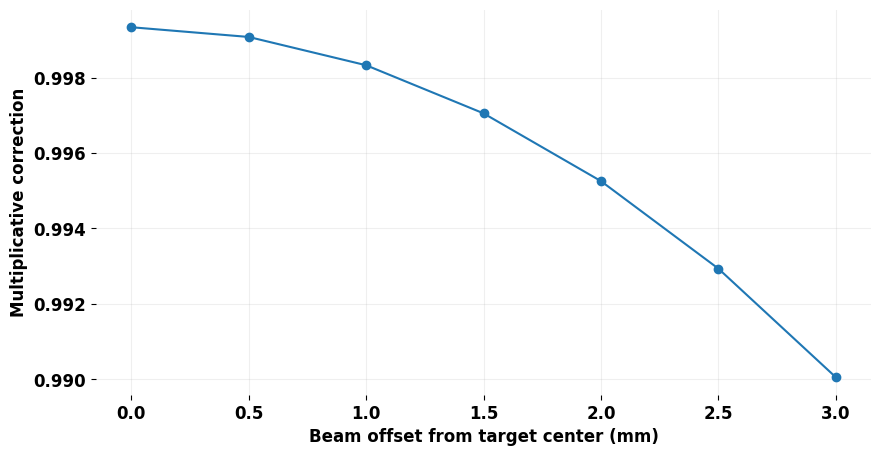

In [9]:
offsets_mm, corr_factors = scan_offsets(xr = 1.0, yr = 1.0, xoff_max = 3.0, step = 0.5, n_samples = 200_000)
import os
os.makedirs('plots', exist_ok = True)
# Simple plot of correction vs beam offset
fig, ax = shaxes(xlabel = 'Beam offset from target center (mm)', ylabel = 'Multiplicative correction')
ax.plot(offsets_mm, corr_factors, marker = fmts[0])
plt.savefig(f'plots/fcorr.png', dpi = 300)